# Part 2: Characterizing population-specific TR variation

This notebook generates the items listed below. For preprocessing see:
* `../size-stats/readme.sh`: summarizes allele frequency info across loci

Figures:
* Figure 2 panels a-f

Supplementary Figures:

Statistics:


In [23]:
####### Set up #########
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import os
import pandas as pd
import seaborn as sns

PLOTDIR = "pdfs"

def GetSuperpopColors(spop):
    if "EUR" in spop: return "blue"
    if "AFR" in spop: return "gold"
    if "AMR" in spop: return "red"
    if "EAS" in spop: return "green"
    if "SAS" in spop: return "purple"
    if "H3" in spop: return "gray"

Populating the interactive namespace from numpy and matplotlib


# Figure 2a-b: distribution of diff from ref

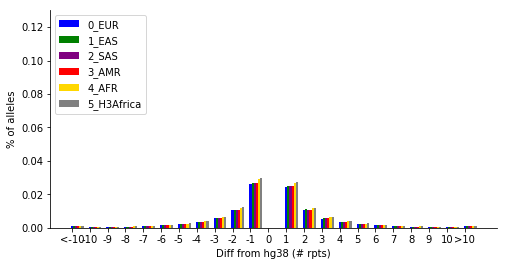

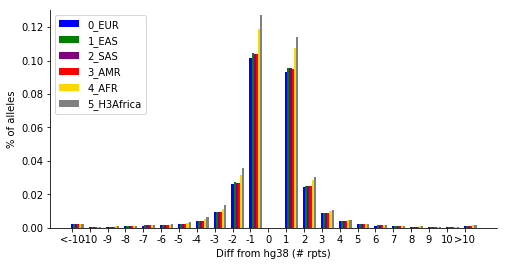

In [22]:
# Load data, sum across all chromosomes
# data gives counts of allele sizes in each sample,
# separately for homopolymers/non-homopolymers
dfs = []
sizecols = list(range(-11, 12))
for chrom in range(1, 22):
    data = pd.read_csv("../size-stats/asize_summary_chr%s.tab"%chrom, sep="\t", 
                  names=["sample","spop","pop","type"] + sizecols)
    dfs.append(data)
data = pd.concat(dfs)

# Aggregate by summarizing across samples/chromosomes
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["spop","type"], as_index=False).agg(aggdict)

w = 0.12
for vtype in ["other","hom"]:
    byspop = data[data["type"]==vtype].copy()
    byspop.index = byspop["spop"]
    byspop = byspop.drop(["spop","type"], 1)
    byspop = byspop.div(byspop.sum(axis=1), axis=0)
    byspop[0] = np.nan

    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    i = 0
    for spop in sorted(list(byspop.index)):
        vals = byspop.loc[spop]
        color = GetSuperpopColors(spop)
        ax.bar([item+w*i for item in sizecols], vals, color=color, label=spop, width=w)
        i += 1
    ax.legend(loc="upper left")
    ax.set_xticks(sizecols)
    ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
    ax.set_xlabel("Diff from hg38 (# rpts)")
    ax.set_ylabel("% of alleles")
    ax.set_ylim(bottom=0, top=0.13)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if vtype == "other":
        figname = "Figure2a-DiffFromRef-Nonhomopolymer.pdf"
    else:
        figname = "Figure2b-DiffFromRef-Homopolymer.pdf"
    fig.savefig(os.path.join(PLOTDIR, figname))

# Figure c: diff from ref vs. allele freq

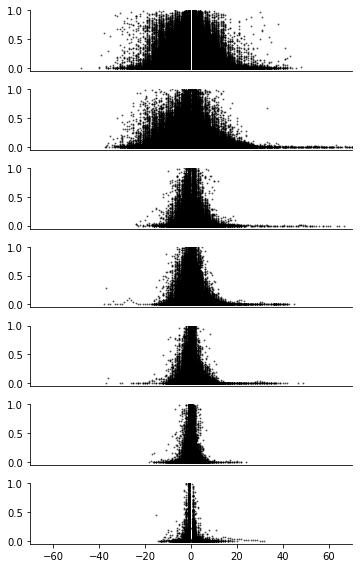

In [25]:
diffs = pd.read_csv("../size-stats/diff_afreqs.tab", sep="\t", names=["chrom","start","period","diff","freq"])

fig = plt.figure()
fig.set_size_inches((5, 8))
for period in range(1, 8):
    if period <= 6:
        xx = diffs[(diffs["period"]==period) & (diffs["diff"].apply(abs) >= 0)]
    else:
        xx = diffs[(diffs["period"]>=period) & (diffs["diff"].apply(abs) >= 0)]
    ax = fig.add_subplot(7, 1, period)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.scatter(xx["diff"], xx["freq"], color="black", s=1, alpha=0.5)
    ax.set_xlim(left=-70, right=70)
    ax.set_ylim(bottom=-0.05, top=1)
    if period != 7: ax.set_xticks([])
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, "Figure2c-DiffVsAfreq.png"))

In [35]:
# Determine position of boxes around NEXN, CA10, CDON repeats

# diffs[(diffs["diff"]>= 20) & (diffs["period"]>6)] # CDON chr11:126065034, box around 20-32
# diffs[(diffs["diff"]>= 20) & (diffs["period"]==3) & (diffs["start"]==77887912 )] # NEXN, box around 20-75
# diffs[(diffs["diff"]>= 20) & (diffs["period"]==3) & (diffs["start"]==51831667 )] # CA10, box around 20-58

# Figure d-f: example allele freq distributions

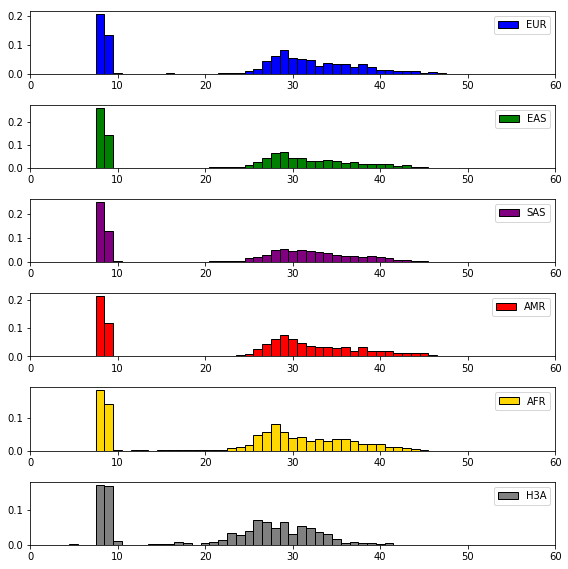

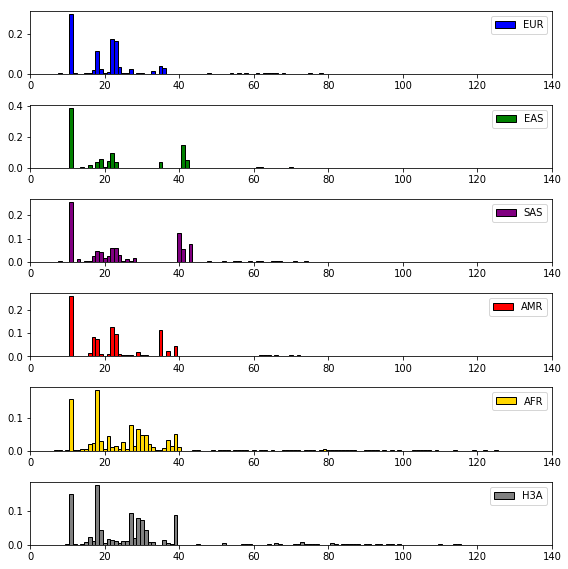

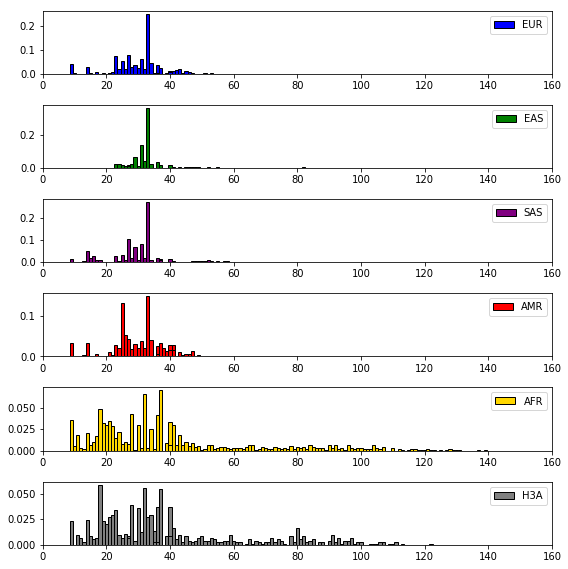

In [46]:
for (chrom, pos, name, maxval, expthresh) in [("chr11", 126065034, "CDON", 60, None), \
                           ("chr17", 51831667, "CA10", 140, 65), \
                          ("chr1", 77887912, "NEXN", 160, 40)]:
    # Run statstr
    cmd = """
    mkdir -p tmp/
    statSTR \
    --vcf /gymreklab-tscc/helia/ensembl/ensemble_out/ensemble_%s_filtered.vcf.gz \
    --vcftype hipstr \
    --afreq --use-length \
    --region %s:%s-%s \
    --samples ../het-stats/EUR_samples.txt,../het-stats/EAS_samples.txt,../het-stats/SAS_samples.txt,../het-stats/AMR_samples.txt,../het-stats/AFR_samples.txt,../het-stats/h3africa_samples.txt \
    --sample-prefixes EUR,EAS,SAS,AMR,AFR,H3A \
    --out tmp/%s.%s.stats
    """%(chrom, chrom, pos, pos, chrom, pos)
    os.system(cmd)
    
    # Load data
    data = pd.read_csv(os.path.join("tmp", "%s.%s.stats.tab")%(chrom, pos), sep="\t")
    if data.shape[0] != 1:
        assert("Need to find exactly one locus!")

    fig = plt.figure()
    fig.set_size_inches((8, 8))
    popnum = 0
    w = 0.15
    for spop in ["EUR","EAS","SAS","AMR","AFR","H3A"]:
        ax = fig.add_subplot(6, 1, popnum+1)
        vals = data["afreq-%s"%spop].values[0]
        xvals = []
        yvals = []
        for ainfo in vals.split(","):
            allele, freq = ainfo.split(":")
            allele = int(float(allele))
            freq = float(freq)
            xvals.append(allele)
            yvals.append(freq)
        ax.bar(xvals, yvals, color=GetSuperpopColors(spop), edgecolor="black", label=spop, width=1)
        if expthresh is not None:
            ax.axvline(x=expthresh, linewidth)
        ax.legend(loc="upper right")
        popnum += 1
        ax.set_xlim(left=0, right=maxval)
    if name == "CDON":
        figname = "Figure2d-AFreq-CDON.pdf"
    if name == "CA10":
        figname = "Figure2e-AFreq-CA10.pdf"
    if name == "NEXN":
        figname = "Figure2f-AFreq-NEXN.pdf"
    fig.savefig(os.path.join(PLOTDIR, figname))
    fig.tight_layout()